In [1]:
from io import BytesIO
from tensorflow.python.lib.io import file_io
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [2]:
def load_numpy_arr(gcs_path: str):
  return BytesIO(file_io.read_file_to_string(gcs_path, binary_mode=True))

# Kuzushiji-49 Image Classification

## Dataset Fetch & Load

In [3]:
k49_ds_train_images_url = "gs://iobruno/datasets/k49/k49-train-imgs.npz"
k49_ds_train_labels_url = "gs://iobruno/datasets/k49/k49-train-labels.npz"

k49_ds_test_images_url = "gs://iobruno/datasets/k49/k49-test-imgs.npz"
k49_ds_test_labels_url = "gs://iobruno/datasets/k49/k49-test-labels.npz"

In [4]:
k49_train_images_raw_gz = np.load(load_numpy_arr(k49_ds_train_images_url))
k49_train_labels_raw_gz = np.load(load_numpy_arr(k49_ds_train_labels_url))

k49_test_images_raw_gz = np.load(load_numpy_arr(k49_ds_test_images_url))
k49_test_labels_raw_gz = np.load(load_numpy_arr(k49_ds_test_labels_url))

In [5]:
print(f"K49 Train files (Arrays): {k49_train_images_raw_gz.files}")
print(f"K49 Train labels (Arrays): {k49_train_labels_raw_gz.files}")
print(f"K49 Test files (Arrays): {k49_test_images_raw_gz.files}")
print(f"K49 Test labels (Arrays): {k49_test_labels_raw_gz.files}")

K49 Train files (Arrays): ['arr_0']
K49 Train labels (Arrays): ['arr_0']
K49 Test files (Arrays): ['arr_0']
K49 Test labels (Arrays): ['arr_0']


In [6]:
k49_train_images_raw = k49_train_images_raw_gz.f.arr_0
k49_train_labels_raw = k49_train_labels_raw_gz.f.arr_0
k49_test_images_raw = k49_test_images_raw_gz.f.arr_0
k49_test_labels_raw = k49_test_labels_raw_gz.f.arr_0

In [7]:
k49_class_names = [f"Class {i+1}" for i in range(49)]

### Training Dataset - EDA

In [8]:
k49_train_images_raw.shape

(232365, 28, 28)

In [9]:
k49_train_labels_raw

array([30, 19, 20, ..., 10, 39, 30], dtype=uint8)

### Test Dataset - EDA

In [10]:
k49_test_images_raw.shape

(38547, 28, 28)

In [11]:
k49_test_labels_raw

array([19, 23, 10, ...,  1, 27, 47], dtype=uint8)

## Dataset Preprocessing

In [12]:
def plot(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [13]:
def multi_plot(images, labels, classes):
    plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(classes[labels[i]])

    plt.show()

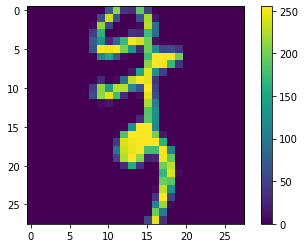

In [14]:
plot(image=k49_train_images_raw[0])

In [15]:
k49_train_images = k49_train_images_raw / 255.0
k49_test_images = k49_test_images_raw / 255.0

In [16]:
k49_train_labels = k49_train_labels_raw
k49_test_labels = k49_test_labels_raw

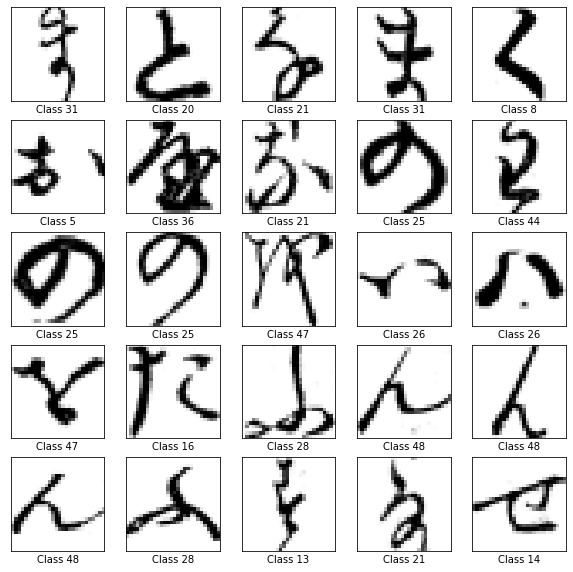

In [17]:
multi_plot(images=k49_train_images, labels=k49_train_labels, classes=k49_class_names)

## Model Training

### Layers Setup

In [18]:
k49_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),  
  tf.keras.layers.Dense(49)
])

### Model Compilation

In [19]:
k49_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

### Model Training

In [20]:
k49_model.fit(k49_train_images, k49_train_labels, epochs=20)

Epoch 1/20
7262/7262 [==============================] - 11s 1ms/step - loss: 1.0152 - accuracy: 0.7361
Epoch 2/20
7262/7262 [==============================] - 9s 1ms/step - loss: 0.3803 - accuracy: 0.8928
Epoch 3/20
7262/7262 [==============================] - 9s 1ms/step - loss: 0.2915 - accuracy: 0.9163
Epoch 4/20
7262/7262 [==============================] - 9s 1ms/step - loss: 0.2472 - accuracy: 0.9282
Epoch 5/20
7262/7262 [==============================] - 9s 1ms/step - loss: 0.2114 - accuracy: 0.9367
Epoch 6/20
7262/7262 [==============================] - 15s 2ms/step - loss: 0.1862 - accuracy: 0.9439
Epoch 7/20
7262/7262 [==============================] - 19s 3ms/step - loss: 0.1701 - accuracy: 0.9493
Epoch 8/20
7262/7262 [==============================] - 13s 2ms/step - loss: 0.1564 - accuracy: 0.9528
Epoch 9/20
7262/7262 [==============================] - 16s 2ms/step - loss: 0.1450 - accuracy: 0.9564
Epoch 10/20
7262/7262 [==============================] - 11s 2ms/step - loss:

### Model Evaluation

In [21]:
k49_test_loss, k49_test_accuracy = k49_model.evaluate(k49_test_images,  k49_test_labels, verbose=2)

1205/1205 - 1s - loss: 1.5708 - accuracy: 0.8431


In [22]:
print(f"Test Loss: {k49_test_loss}")
print(f"Test Accuracy: {k49_test_accuracy}")

Test Loss: 1.5707826614379883
Test Accuracy: 0.8431006073951721


## Model Inference

In [23]:
k49_probability_model = tf.keras.Sequential([k49_model, tf.keras.layers.Softmax()])

In [24]:
k49_predictions = k49_probability_model.predict(k49_test_images)

In [25]:
k49_predictions[0]

array([5.7929882e-24, 0.0000000e+00, 5.0685422e-25, 8.8926394e-20,
       1.0059850e-28, 1.9456028e-25, 5.5694461e-17, 3.6825076e-20,
       3.7739097e-19, 5.4715249e-13, 7.6154038e-25, 1.6434139e-13,
       6.1167441e-14, 5.6652675e-26, 5.2523164e-10, 2.9800171e-14,
       0.0000000e+00, 3.1976244e-35, 3.4054578e-16, 1.0000000e+00,
       1.4470319e-30, 4.6970446e-20, 1.2356227e-29, 7.6059235e-29,
       8.4422823e-27, 7.4887606e-18, 0.0000000e+00, 0.0000000e+00,
       8.7873250e-28, 1.6109145e-24, 8.9950605e-20, 1.1695129e-08,
       0.0000000e+00, 7.7385339e-28, 3.9652380e-14, 4.4962400e-32,
       8.4673600e-38, 1.8792157e-17, 4.0280036e-18, 2.0309961e-23,
       4.5349167e-22, 8.1635993e-16, 0.0000000e+00, 4.5265308e-16,
       1.1390500e-32, 1.6202015e-32, 1.6091232e-29, 1.4023654e-17,
       1.5167687e-26], dtype=float32)

In [26]:
np.argmax(k49_predictions[0])

19

In [27]:
k49_test_labels[0]

19

### Setting up ground work

In [28]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  color = 'blue' if predicted_label == true_label else 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(
      k49_class_names[predicted_label],
      100*np.max(predictions_array),
      k49_class_names[true_label]
), color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(49))
  plt.yticks([])
  thisplot = plt.bar(range(49), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

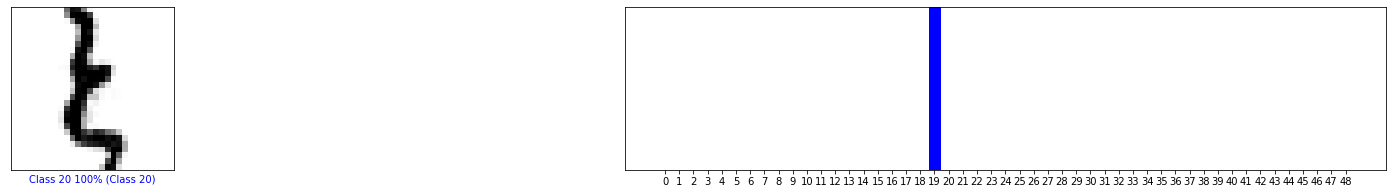

In [29]:
plt.figure(figsize=(30,3))
i = 0

# Image
plt.subplot(1,2,1)
plot_image(i, k49_predictions[i], k49_test_labels, k49_test_images)

# Accuracy
plt.subplot(1,2,2)
plot_value_array(i, k49_predictions[i],  k49_test_labels)

plt.show()

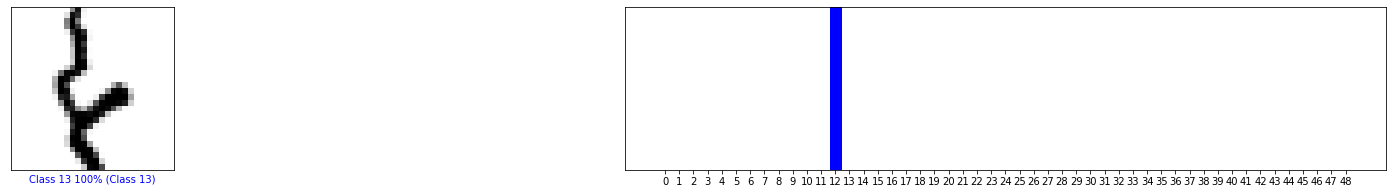

In [30]:
plt.figure(figsize=(30,3))
i = 12

# Image
plt.subplot(1,2,1)
plot_image(i, k49_predictions[i], k49_test_labels, k49_test_images)

# Accuracy
plt.subplot(1,2,2)
plot_value_array(i, k49_predictions[i],  k49_test_labels)

plt.show()

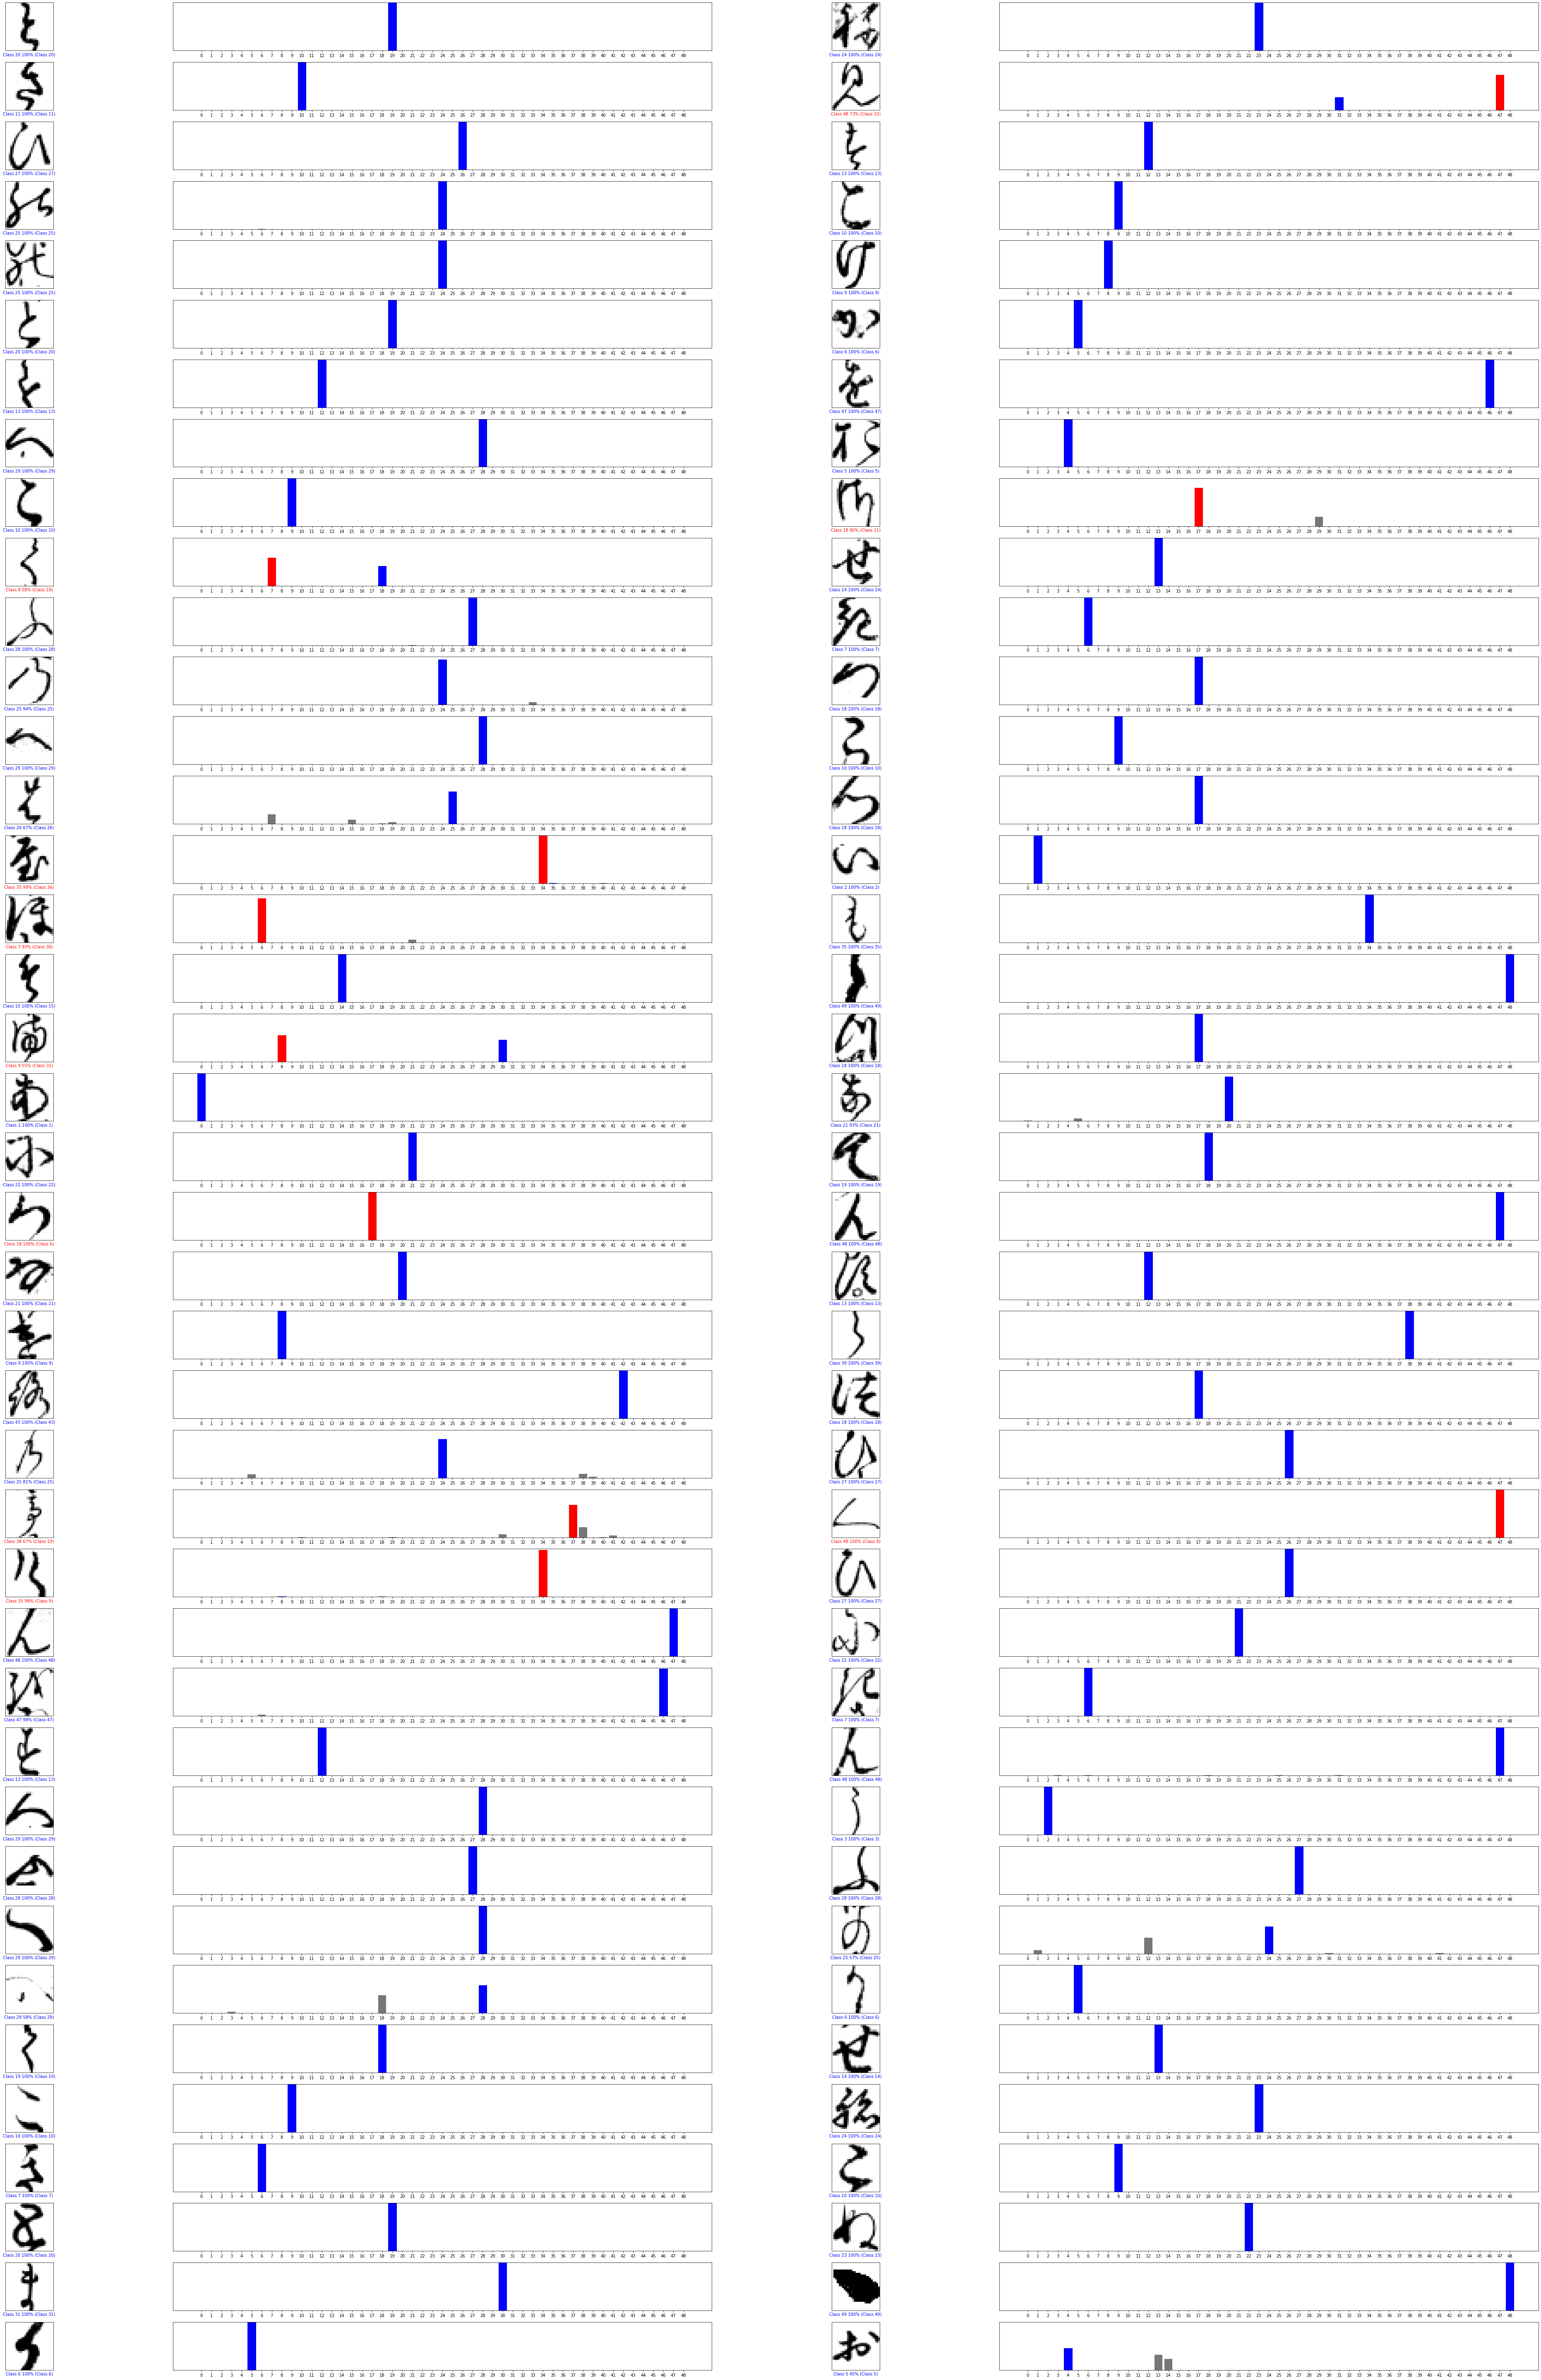

In [31]:
num_rows = 40
num_cols = 2
num_images = num_rows*num_cols

plt.figure(figsize=(30*num_cols, 2*num_rows))

for i in range(num_images):
  # Image
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, k49_predictions[i], k49_test_labels, k49_test_images)
  # Accuracy
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, k49_predictions[i], k49_test_labels)
    
plt.tight_layout()
plt.show()

# Kuzushiji-MNIST Image Classification

## Dataset Fetch & Load

In [32]:
kmnist_ds_train_images_url = "gs://iobruno/datasets/kmnist/kmnist-train-imgs.npz"
kmnist_ds_train_labels_url = "gs://iobruno/datasets/kmnist/kmnist-train-labels.npz"

kmnist_ds_test_images_url = "gs://iobruno/datasets/kmnist/kmnist-test-imgs.npz"
kmnist_ds_test_labels_url = "gs://iobruno/datasets/kmnist/kmnist-test-labels.npz"

In [33]:
kmnist_train_images_raw_gz = np.load(load_numpy_arr(kmnist_ds_train_images_url))
kmnist_train_labels_raw_gz = np.load(load_numpy_arr(kmnist_ds_train_labels_url))

kmnist_test_images_raw_gz = np.load(load_numpy_arr(kmnist_ds_test_images_url))
kmnist_test_labels_raw_gz = np.load(load_numpy_arr(kmnist_ds_test_labels_url))

In [34]:
print(f"KMNIST Train files (Arrays): {kmnist_train_images_raw_gz.files}")
print(f"KMNIST Train labels (Arrays): {kmnist_train_labels_raw_gz.files}")
print(f"KMNIST Test files (Arrays): {kmnist_test_images_raw_gz.files}")
print(f"KMNIST Test labels (Arrays): {kmnist_test_labels_raw_gz.files}")

KMNIST Train files (Arrays): ['arr_0']
KMNIST Train labels (Arrays): ['arr_0']
KMNIST Test files (Arrays): ['arr_0']
KMNIST Test labels (Arrays): ['arr_0']


In [35]:
kmnist_train_images_raw = kmnist_train_images_raw_gz.f.arr_0
kmnist_train_labels_raw = kmnist_train_labels_raw_gz.f.arr_0
kmnist_test_images_raw = kmnist_test_images_raw_gz.f.arr_0
kmnist_test_labels_raw = kmnist_test_labels_raw_gz.f.arr_0

In [36]:
kmnist_class_names = ["A", "B", "C", "D", "E", 
                      "F", "G", "H", "I", "J"]

### Training Dataset - EDA

In [37]:
kmnist_train_images_raw.shape

(60000, 28, 28)

In [38]:
set(kmnist_train_labels_raw)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

### Test Dataset - EDA

In [39]:
kmnist_test_images_raw.shape

(10000, 28, 28)

In [40]:
set(kmnist_test_labels_raw)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Dataset Preprocessing

In [41]:
def plot(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

In [42]:
def multi_plot(images, labels, classes):
    plt.figure(figsize=(10,10))
    
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(classes[labels[i]])

    plt.show()

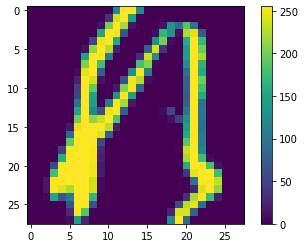

In [43]:
plot(image=kmnist_train_images_raw[0])

In [44]:
kmnist_train_images = kmnist_train_images_raw / 255.0
kmnist_test_images = kmnist_test_images_raw / 255.0

In [45]:
kmnist_train_labels = kmnist_train_labels_raw
kmnist_test_labels = kmnist_test_labels_raw

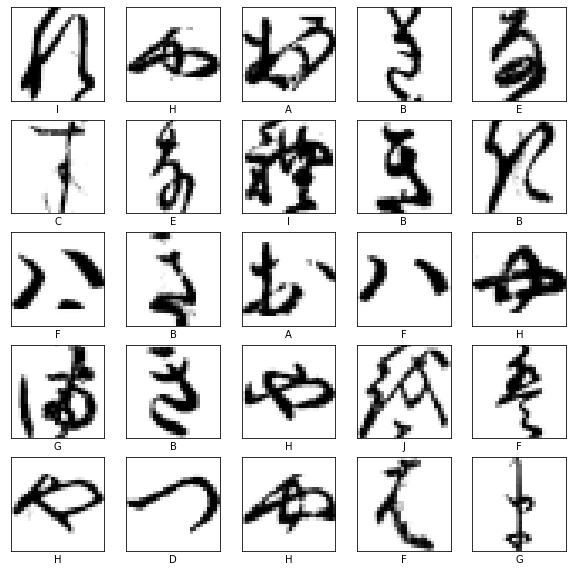

In [46]:
multi_plot(images=kmnist_train_images, labels=kmnist_train_labels, classes=kmnist_class_names)

## Model Training

### Layers Setup

In [47]:
kmnist_model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dense(10)
])

### Model Compilation

In [48]:
kmnist_model.compile(optimizer='adam',
                     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                     metrics=['accuracy'])

### Model Training

In [49]:
kmnist_model.fit(kmnist_train_images, kmnist_train_labels, epochs=10)

Epoch 1/10
1875/1875 [==============================] - 3s 1ms/step - loss: 0.5142 - accuracy: 0.8436
Epoch 2/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1402 - accuracy: 0.9573
Epoch 3/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0809 - accuracy: 0.9739
Epoch 4/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0589 - accuracy: 0.9811
Epoch 5/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0404 - accuracy: 0.9867
Epoch 6/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0345 - accuracy: 0.9887
Epoch 7/10
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0305 - accuracy: 0.9900
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0190 - accuracy: 0.9937
Epoch 9/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.0232 - accuracy: 0.9928
Epoch 10/10
1875/1875 [==============================] - 4s 2ms/step - loss: 0.016

### Model Evaluation

In [50]:
kmnist_test_loss, kmnist_test_accuracy = kmnist_model.evaluate(kmnist_test_images,  kmnist_test_labels, verbose=2)

313/313 - 0s - loss: 0.6471 - accuracy: 0.9088


In [51]:
print(f"Test Loss: {kmnist_test_loss}")
print(f"Test Accuracy: {kmnist_test_accuracy}")

Test Loss: 0.6470832228660583
Test Accuracy: 0.9088000059127808


## Model Inference

In [52]:
kmnist_probability_model = tf.keras.Sequential([kmnist_model, tf.keras.layers.Softmax()])

In [53]:
kmnist_predictions = kmnist_probability_model.predict(kmnist_test_images)

In [54]:
kmnist_predictions[0]

array([5.7595775e-11, 1.0709368e-04, 9.9987984e-01, 1.0931569e-05,
       3.6819191e-08, 2.0714135e-06, 9.0029211e-09, 3.7901180e-12,
       1.0414027e-09, 3.4935990e-08], dtype=float32)

In [55]:
np.argmax(kmnist_predictions[0])

2

In [56]:
kmnist_test_labels[0]

2

### Setting up ground work

In [57]:
def kminst_plot_image(i, predictions_array, true_label, img):
  true_label, img = true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  color = 'blue' if predicted_label == true_label else 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(kmnist_class_names[predicted_label],
                                100*np.max(predictions_array),
                                kmnist_class_names[true_label]),
                                color=color)

def kmnist_plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

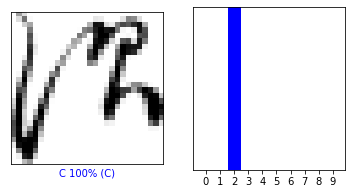

In [58]:
plt.figure(figsize=(6,3))
i = 0

# Image
plt.subplot(1,2,1)
kminst_plot_image(i, kmnist_predictions[i], kmnist_test_labels, kmnist_test_images)

# Accuracy
plt.subplot(1,2,2)
kmnist_plot_value_array(i, kmnist_predictions[i],  kmnist_test_labels)

plt.show()

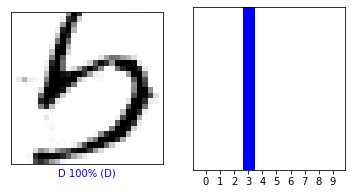

In [59]:
plt.figure(figsize=(6,3))
i = 12

# Image
plt.subplot(1,2,1)
kminst_plot_image(i, kmnist_predictions[i], kmnist_test_labels, kmnist_test_images)

# Accuracy
plt.subplot(1,2,2)
kmnist_plot_value_array(i, kmnist_predictions[i],  kmnist_test_labels)

plt.show()

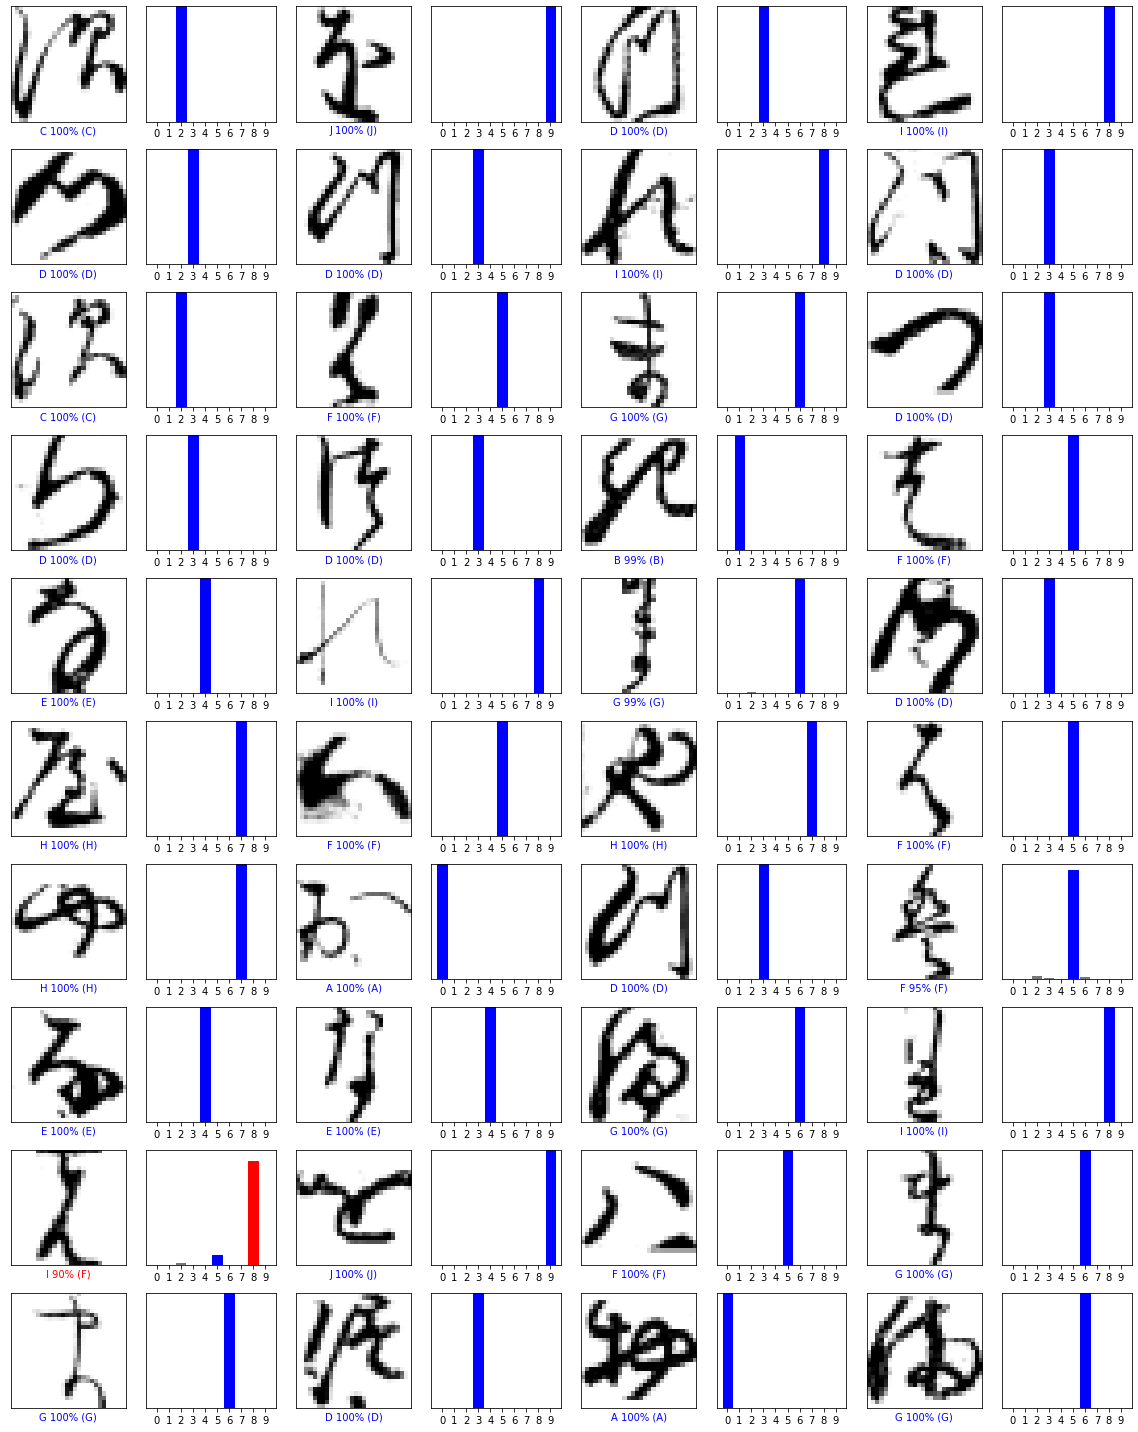

In [60]:
num_rows = 10
num_cols = 4
num_images = num_rows*num_cols

plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(num_images):
  # Image
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  kminst_plot_image(i, kmnist_predictions[i], kmnist_test_labels, kmnist_test_images)
  # Accuracy
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  kmnist_plot_value_array(i, kmnist_predictions[i], kmnist_test_labels)
    
plt.tight_layout()
plt.show()